# March Madness 2025 Prediction Pipeline

This notebook orchestrates the complete end-to-end prediction process for the 2025 March Madness tournaments (both men's and women's). It uses the ELO-enhanced machine learning approach to generate predictions.

## Pipeline Steps
1. Load and preprocess data for both men's and women's tournaments
2. Calculate ELO ratings and advanced statistics
3. Train ELO-enhanced ML models for both tournaments
4. Generate predictions for all possible matchups
5. Identify and visualize predictions for actual tournament teams
6. Create consolidated submission file

## 1. Import Required Libraries and Configure Settings

In [ ]:
# Enable auto-reloading of modules
%load_ext autoreload
%autoreload 2

# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set a nice plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Import our custom classes
from data_classes.processing import (
    MarchMadnessDataManager, 
    EloRatingSystem, 
    TeamStatsCalculator,
    MarchMadnessMLModel,
    MarchMadnessPredictor
)
from data_classes.bracket import BracketSimulator

In [ ]:
# Configuration
CURRENT_SEASON = 2025                 # Target season
DATA_DIR = f"../data/{CURRENT_SEASON}"    # Directory for men's tournament data
ELO_START_YEAR = 2003                 # First year for ELO calculations
ML_START_YEAR = 2019                 # First year for ML training
SUBMISSION_FILE = "output/submission_2025.csv"  # Combined submission file
PERFORM_TUNING = False

# Ensure output directory exists
os.makedirs("output", exist_ok=True)

## 2. Initialize Tournament Components

In [ ]:
# Initialize data manager for men's tournament
men_data_manager = MarchMadnessDataManager(DATA_DIR, "M", CURRENT_SEASON)

# Load all data files for men's tournament
men_data = men_data_manager.load_data()

# Display summary of loaded data
print("Loaded men's tournament data files:")
for key, df in men_data.items():
    print(f"  - {key}: {df.shape[0]} rows, {df.shape[1]} columns")

In [ ]:
# Initialize ELO rating systems (with temporary default parameters)
men_elo_system = EloRatingSystem(men_data_manager)

# Initialize stats calculators (don't calculate stats yet)
men_stats_calculator = TeamStatsCalculator(men_data_manager)

# Initialize ML models (without training them)
men_ml_model = MarchMadnessMLModel(men_data_manager, men_elo_system, men_stats_calculator)

# Initialize predictors
men_predictor = MarchMadnessPredictor(
    data_manager=men_data_manager,
    elo_system=men_elo_system,
    stats_calculator=men_stats_calculator,
    ml_model=men_ml_model,
    current_season=CURRENT_SEASON
)

In [ ]:
# Initialize data manager for women's tournament
women_data_manager = MarchMadnessDataManager(DATA_DIR, "W", CURRENT_SEASON)

# Load all data files for women's tournament
women_data = women_data_manager.load_data()

# Display summary of loaded data
print("Loaded women's tournament data files:")
for key, df in women_data.items():
    print(f"  - {key}: {df.shape[0]} rows, {df.shape[1]} columns")

In [ ]:

women_stats_calculator = TeamStatsCalculator(women_data_manager)
women_elo_system = EloRatingSystem(women_data_manager)
women_ml_model = MarchMadnessMLModel(women_data_manager, women_elo_system, women_stats_calculator)
women_predictor = MarchMadnessPredictor(
    data_manager=women_data_manager,
    elo_system=women_elo_system,
    stats_calculator=women_stats_calculator,
    ml_model=women_ml_model,
    current_season=CURRENT_SEASON
)

In [ ]:
if PERFORM_TUNING:
    TEST_SEASONS = [2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024]
    # Perform ELO parameter tuning
    print("Tuning ELO parameters for men's tournament...")
    # For faster testing, use a smaller parameter grid and fewer test seasons
    men_elo_tuning = men_predictor.tune_elo_parameters(
        test_seasons=TEST_SEASONS,  # Adjust years as needed
    )

    # Get optimal parameters
    men_best_k = men_elo_tuning.iloc[0]['k_factor']
    men_best_rf = men_elo_tuning.iloc[0]['recency_factor']
    men_best_rw = men_elo_tuning.iloc[0]['recency_window']
    men_best_co = men_elo_tuning.iloc[0]['carry_over_factor']
    print(f"Optimal men's parameters: k={men_best_k}, rf={men_best_rf}, rw={men_best_rw}, co={men_best_co}")

    # Same for women
    print("\nTuning ELO parameters for women's tournament...")
    women_elo_tuning = women_predictor.tune_elo_parameters(
        test_seasons=TEST_SEASONS # Adjust years as needed
    )

    # Get optimal parameters
    women_best_k = women_elo_tuning.iloc[0]['k_factor']
    women_best_rf = women_elo_tuning.iloc[0]['recency_factor'] 
    women_best_rw = women_elo_tuning.iloc[0]['recency_window']
    women_best_co = women_elo_tuning.iloc[0]['carry_over_factor']
    print(f"Optimal women's parameters: k={women_best_k}, rf={women_best_rf}, rw={women_best_rw}, co={women_best_co}")

    # Save tuning results
    men_elo_tuning.to_csv('output/men_elo_tuning_results.csv', index=False)
    women_elo_tuning.to_csv('output/women_elo_tuning_results.csv', index=False)
else:
    print("Skipping parameter tuning. Using pre-defined values.")
    # Use fixed parameter values (e.g. from previous tuning runs)
    men_best_k = 10 
    men_best_rf = 3.0
    men_best_rw = 25
    men_best_co = 0.7
    women_best_k = 40
    women_best_rf = 3.0
    women_best_rw = 20
    women_best_co = 0.7

## 3. Men's Tournament

In [ ]:
men_elo_ratings = men_elo_system.calculate_elo_ratings(
    start_year=ELO_START_YEAR,
    k_factor=men_best_k,            # Use optimized value
    recency_factor=men_best_rf,     # Use optimized value
    recency_window=men_best_rw,     # Use optimized value
    home_advantage=100,
    carry_over_factor=men_best_co,
    output_path="output/M_elo_ratings.csv"
)

# Get current ELO ratings for the tournament teams
men_current_elo = men_elo_system.get_all_teams_elo(CURRENT_SEASON)

# Display top 10 men's teams by ELO rating
print("\nTop 10 men's teams by ELO rating:")
display(men_current_elo.sort_values('ELO', ascending=False).head(10))

In [ ]:
# Initialize stats calculator for men's tournament
men_stats_calculator = TeamStatsCalculator(men_data_manager)

try:
    # Calculate advanced statistics
    print("Calculating advanced statistics for men's teams...")
    men_advanced_stats = men_stats_calculator.calculate_advanced_team_stats(start_season=ELO_START_YEAR)
    
    # Success message
    print(f"Calculated advanced statistics for {len(men_advanced_stats)} seasons")
except Exception as e:
    print(f"Error calculating advanced stats: {e}")

In [ ]:
# Initialize ML model for men's tournament
men_ml_model = MarchMadnessMLModel(
    men_data_manager,
    men_elo_system,
    men_stats_calculator
)
# Train ELO-enhanced ML model
print("Training ELO-enhanced ML model for men's tournament...")
men_ml_model.train_model(
    model_type='xgboost',
    test_size=0.2,
    random_state=42
)

In [ ]:
# Initialize the predictor for men's tournament
men_predictor = MarchMadnessPredictor(
    data_manager=men_data_manager,
    elo_system=men_elo_system,
    stats_calculator=men_stats_calculator,
    ml_model=men_ml_model,
    current_season=CURRENT_SEASON
)

## 4. Women's Tournament Components

In [ ]:
women_elo_ratings = women_elo_system.calculate_elo_ratings(
    start_year=ELO_START_YEAR,
    k_factor=women_best_k,            # Use optimized value
    recency_factor=women_best_rf,     # Use optimized value
    recency_window=women_best_rw,     # Use optimized value
    home_advantage=100,
    carry_over_factor=women_best_co,
    output_path="output/W_elo_ratings.csv"
)

# Get current ELO ratings for the tournament teams
women_current_elo = women_elo_system.get_all_teams_elo(CURRENT_SEASON)

# Display top 10 women's teams by ELO rating
print("\nTop 10 women's teams by ELO rating:")
display(women_current_elo.sort_values('ELO', ascending=False).head(10))

In [ ]:
# Initialize stats calculator for women's tournament
women_stats_calculator = TeamStatsCalculator(women_data_manager)

try:
    # Calculate advanced statistics
    print("Calculating advanced statistics for women's teams...")
    women_advanced_stats = women_stats_calculator.calculate_advanced_team_stats(start_season=ELO_START_YEAR)
    
    # Success message
    print(f"Calculated advanced statistics for {len(women_advanced_stats)} seasons")
except Exception as e:
    print(f"Error calculating advanced stats: {e}")

In [ ]:
# Initialize ML model for women's tournament
women_ml_model = MarchMadnessMLModel(
    women_data_manager,
    women_elo_system,
    women_stats_calculator
)

# Train ELO-enhanced ML model
print("Training ELO-enhanced ML model for women's tournament...")
women_ml_model.train_model(
    model_type='xgboost',
    test_size=0.2,
    random_state=42
)

In [ ]:
# Initialize the predictor for women's tournament
women_predictor = MarchMadnessPredictor(
    data_manager=women_data_manager,
    elo_system=women_elo_system,
    stats_calculator=women_stats_calculator,
    ml_model=women_ml_model,
    current_season=CURRENT_SEASON
)

## 5. Evaluate Model Performance with Backtesting

In [ ]:
def evaluate_historical_tournaments(predictor, seasons=[2018, 2019, 2021, 2022, 2023], method="elo_enhanced", gender="M"):
    """Evaluate and visualize predictions for multiple historical tournaments"""
    import matplotlib.pyplot as plt
    import pandas as pd
    from IPython.display import display
    
    results = []
    
    for season in seasons:
        try:
            print(f"\nEvaluating {season} tournament predictions...")
            
            # Create simulator for this season
            simulator = BracketSimulator(predictor)
            simulator.use_predictor_data(season=season)
            
            # Visualize historical bracket
            fig = simulator.visualize_historical_bracket(
                season,
                method=method,
                output_path=f"output/{gender}_historical_{season}_bracket.png"
            )
            
            # Get accuracy metrics from simulation
            _, metrics = simulator.simulate_historical_bracket(season, method=method)
            results.append({"season": season, **metrics})
            
        except Exception as e:
            print(f"Error processing {season} tournament: {str(e)}")
    
    # Display aggregate results
    if results:
        # Create a DataFrame
        results_df = pd.DataFrame(results)
        
        # Calculate aggregate metrics
        total_correct = results_df['correct'].sum()
        total_games = results_df['total'].sum()
        overall_accuracy = total_correct / total_games if total_games > 0 else 0
        
        print("\nHistorical Tournament Prediction Results:")
        print(f"Overall Accuracy: {overall_accuracy:.2%} ({total_correct}/{total_games} games)")
        print("\nBy Season:")
        display(results_df)
        
        # Plot accuracy by season
        plt.figure(figsize=(10, 6))
        plt.bar(results_df['season'], results_df['accuracy'])
        plt.xlabel('Tournament Season')
        plt.ylabel('Prediction Accuracy')
        plt.title(f'Tournament Prediction Accuracy by Season ({method})')
        plt.ylim(0, 1)
        plt.grid(axis='y', alpha=0.3)
        
        # Add accuracy labels on top of the bars
        for i, row in results_df.iterrows():
            plt.text(row['season'], row['accuracy'] + 0.02, 
                     f"{row['accuracy']:.2%}\n({row['correct']}/{row['total']})",
                     ha='center')
        
        plt.tight_layout()
        plt.show()
    
    return results

In [ ]:
men_historical_results = evaluate_historical_tournaments(
    men_predictor,  # Your existing predictor instance
    seasons=[2021, 2022, 2023, 2024],  # Skip 2020 (cancelled)
    method="elo_enhanced"  # Use your best method
)

In [ ]:
women_historical_results = evaluate_historical_tournaments(
    women_predictor,  # Your existing predictor instance
    seasons=[2021, 2022, 2023, 2024],  # Skip 2020 (cancelled)
    method="elo_enhanced",  # Use your best method
    gender="W"
)

In [ ]:
# Compare men's prediction methods on historical tournaments
print("Comparing prediction methods for men's tournament...")
men_comparison = men_predictor.compare_methods(visualize=True)

# Extract the best method for men's predictions
men_best_method = men_comparison.loc[men_comparison['Log Loss'].idxmin(), 'Method']
print(f"\nBest method for men's tournament based on backtesting: {men_best_method}")

In [ ]:
# Compare women's prediction methods on historical tournaments
print("Comparing prediction methods for women's tournament...")
women_comparison = women_predictor.compare_methods(visualize=True)

# Extract the best method for women's predictions
women_best_method = women_comparison.loc[women_comparison['Log Loss'].idxmin(), 'Method']
print(f"\nBest method for women's tournament based on backtesting: {women_best_method}")

## 6. Generate Predictions for Submission

In [ ]:
# Generate men's tournament predictions using the best method
print(f"Generating men's tournament predictions using {men_best_method} method...")
men_predictions = men_predictor.generate_predictions(
    method=men_best_method,
    get_all_matchups=True,
    submission_file="output/submission_2025_M.csv"
)

print(f"Generated {len(men_predictions)} predictions for men's tournament")
display(men_predictions.head())

In [ ]:
# Generate women's tournament predictions using the best method
print(f"Generating women's tournament predictions using {women_best_method} method...")
women_predictions = women_predictor.generate_predictions(
    method=women_best_method,
    get_all_matchups=True,
    submission_file="output/submission_2025_W.csv"
)

print(f"Generated {len(women_predictions)} predictions for women's tournament")
display(women_predictions.head())

## 6. Create Combined Submission File

In [ ]:
# Extract required columns for submission
men_submission = men_predictions[['ID', 'Pred']].copy()
women_submission = women_predictions[['ID', 'Pred']].copy()

# Combine men's and women's predictions
combined_submission = pd.concat([men_submission, women_submission])

# Drop any duplicates (should not happen, but just in case)
combined_submission = combined_submission.drop_duplicates(subset=['ID'])

# Save combined submission file
combined_submission.to_csv(SUBMISSION_FILE, index=False)

print(f"Saved {len(combined_submission)} predictions to {SUBMISSION_FILE}")
print(f"  - Men's predictions: {len(men_submission)}")
print(f"  - Women's predictions: {len(women_submission)}")

## 7. Tournament Team Prediction and Visualization

This section will work once the tournament bracket is released with the actual tournament teams.

Generating men's tournament bracket visualization...
Loaded 66066 matchup predictions from submission file
Saved bracket to output/2025_mens_bracket.png


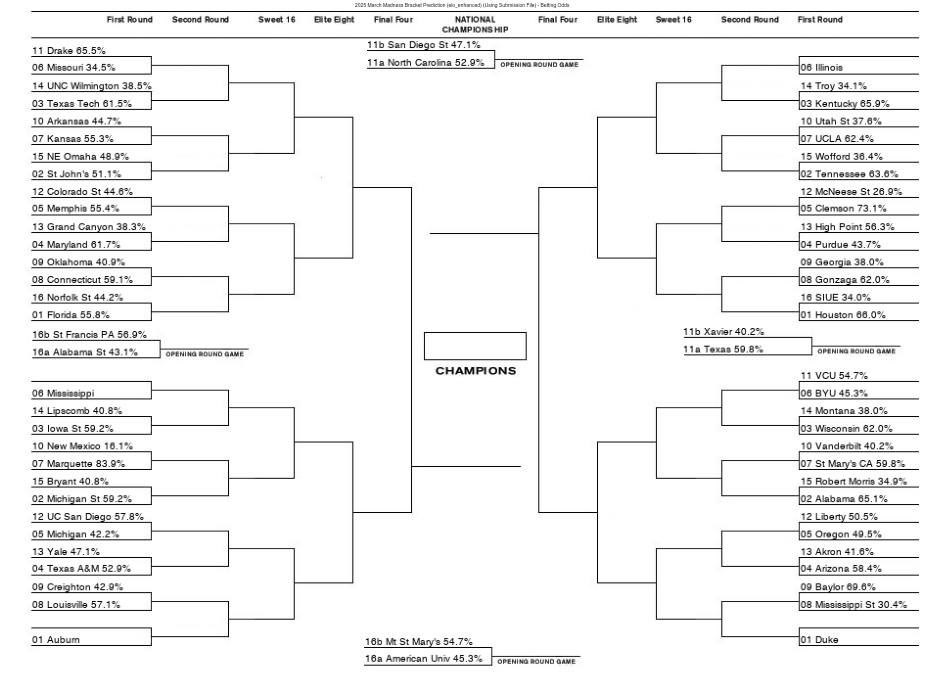

Loaded 66066 matchup predictions from submission file
Saved bracket to output/2025_mens_bracket_prob.png


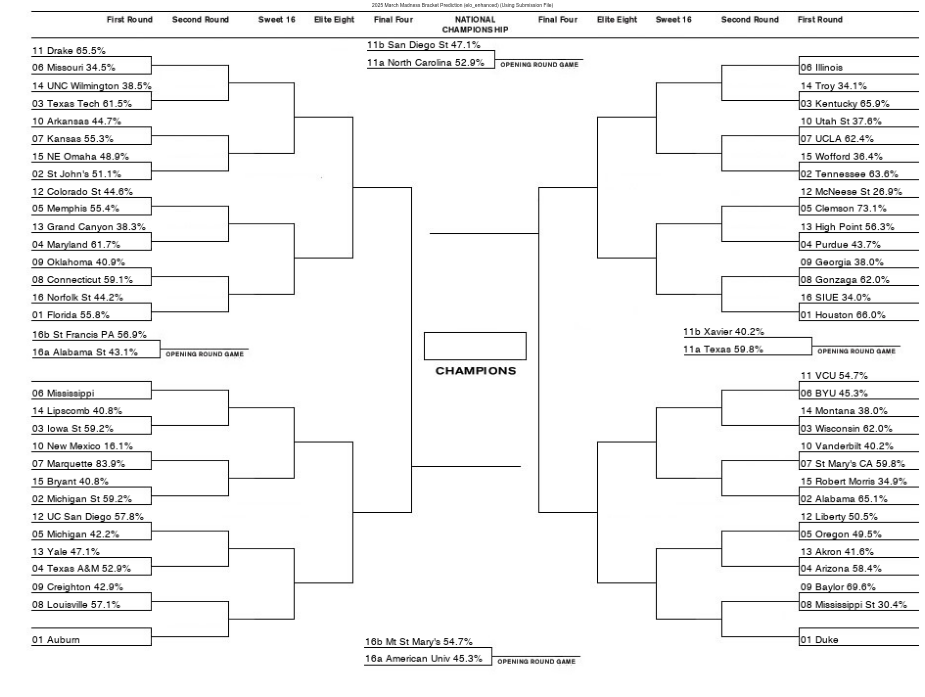

Saved men's bracket visualization to output/2025_mens_bracket.png


In [66]:
# Visualize Men's Tournament Bracket
try:
    # Generate predictions for actual tournament teams
    # men_tourney_predictions = men_predictor.predict_tournament_bracket(method=men_best_method)
    # print(f"Generated predictions for {len(men_tourney_predictions)//2} matchups between men's tournament teams")
    
    # Initialize the bracket simulator
    men_simulator = BracketSimulator(men_predictor)
    men_simulator.use_predictor_data()
    
    # Build the bracket structure
    men_bracket_tree, men_seed_slot_map = men_simulator.build_bracket_tree()
    
    # Generate the bracket visualization
    print("Generating men's tournament bracket visualization...")
    # Use submission file for accurate probabilities
    submission_file = f"output/submission_{CURRENT_SEASON}_M.csv"
    if not os.path.exists(submission_file):
        submission_file = f"output/submission_{CURRENT_SEASON}.csv"
        
    men_simulator.visualize_bracket(
        method=men_best_method,
        output_path=f"output/{CURRENT_SEASON}_mens_bracket.png",
        betting_odds=True,
        submission_file=submission_file
    )

    men_simulator.visualize_bracket(
        method=men_best_method,
        output_path=f"output/{CURRENT_SEASON}_mens_bracket_prob.png",
        betting_odds=False,
        submission_file=submission_file
    )
    
    print(f"Saved men's bracket visualization to output/{CURRENT_SEASON}_mens_bracket.png")
except Exception as e:
    print(f"Could not generate men's tournament bracket: {e}")
    print("This functionality will work once the tournament bracket is released.")

In [ ]:
# Visualize Women's Tournament Bracket
try:
    # Generate predictions for actual tournament teams
    women_tourney_predictions = women_predictor.predict_tournament_bracket(method=women_best_method)
    print(f"Generated predictions for {len(women_tourney_predictions)//2} matchups between women's tournament teams")
    
    # Initialize the bracket simulator
    women_simulator = BracketSimulator(women_predictor)
    women_simulator.use_predictor_data()
    
    # Build the bracket structure
    women_bracket_tree, women_seed_slot_map = women_simulator.build_bracket_tree()
    
    # Generate the bracket visualization
    print("Generating women's tournament bracket visualization...")
    # Use submission file for accurate probabilities
    submission_file = f"output/submission_{CURRENT_SEASON}_W.csv"
    if not os.path.exists(submission_file):
        submission_file = f"output/submission_{CURRENT_SEASON}.csv"
        
    women_simulator.visualize_bracket(
        method=women_best_method,
        output_path=f"output/{CURRENT_SEASON}_womens_bracket.png",
        betting_odds=True,
        submission_file=submission_file
    )
    
    print(f"Saved women's bracket visualization to output/{CURRENT_SEASON}_womens_bracket.png")
except Exception as e:
    print(f"Could not generate women's tournament bracket: {e}")
    print("This functionality will work once the tournament bracket is released.")

In [ ]:
# Define a function to explore a specific team's path through the tournament
def explore_team_path(team_name, simulator: BracketSimulator, data_manager: MarchMadnessDataManager, gender="Men's"):
    # Get the team ID from the name
    team_id = None
    teams_df = data_manager.data['teams']
    matching_teams = teams_df[teams_df['TeamName'].str.contains(team_name, case=False)]
    
    if len(matching_teams) == 0:
        print(f"No {gender.lower()} teams found matching '{team_name}'")
        return
    elif len(matching_teams) > 1:
        print(f"Multiple {gender.lower()} teams found matching '{team_name}':")
        for _, team in matching_teams.iterrows():
            print(f"  - {team['TeamName']} (ID: {team['TeamID']})")
        team_id = matching_teams.iloc[0]['TeamID']
        print(f"Using first match: {matching_teams.iloc[0]['TeamName']} (ID: {team_id})")
    else:
        team_id = matching_teams.iloc[0]['TeamID']
    
    try:
        # Get the team's seed
        team_seed = data_manager.seed_lookup.get((CURRENT_SEASON, team_id), "Unknown")
        print(f"\nExploring {gender} tournament path for {team_seed} seed {data_manager.get_team_name(team_id)} (ID: {team_id})")
        
        # Get the team's tournament path
        path = simulator.get_team_path(team_id)
        
        # Create a DataFrame for the path
        path_df = pd.DataFrame([
            {
                "Round": p["round"],
                "Opponent": p["opponent_name"],
                "Opponent Seed": p["opponent_seed"],
                "Win Probability": f"{p['win_probability']:.1%}"
            }
            for p in path
        ])
        
        display(path_df)
        
        # Calculate championship probability
        champ_prob = np.prod([p["win_probability"] for p in path])
        print(f"Championship probability: {champ_prob:.2%}")
        
    except Exception as e:
        print(f"Error getting team path: {e}")
        print("This functionality will work once the tournament bracket is released.")

In [67]:
from enhanced_bracket_analysis import generate_enhanced_analysis
# Pass your already-initialized predictor with all data loaded
output_file = generate_enhanced_analysis(
    ml_model=men_ml_model,
    simulator=men_simulator,
)

Using max day number for season 2025: 132
Setting up ML components to generate fresh feature data...
Team profile saved to ./output/analysis/team_profile_1181.md
Team profile saved to ./output/analysis/team_profile_1104.md
Team profile saved to ./output/analysis/team_profile_1458.md
Team profile saved to ./output/analysis/team_profile_1112.md
Team profile saved to ./output/analysis/team_profile_1332.md
Team profile saved to ./output/analysis/team_profile_1140.md
Team profile saved to ./output/analysis/team_profile_1388.md
Team profile saved to ./output/analysis/team_profile_1280.md
Team profile saved to ./output/analysis/team_profile_1124.md
Team profile saved to ./output/analysis/team_profile_1435.md
Team profile saved to ./output/analysis/team_profile_1433.md
Team profile saved to ./output/analysis/team_profile_1251.md
Team profile saved to ./output/analysis/team_profile_1103.md
Team profile saved to ./output/analysis/team_profile_1285.md
Team profile saved to ./output/analysis/team_

In [ ]:
from enhanced_bracket_analysis import (
    generate_enhanced_analysis,
    load_elo_data,
    load_feature_data,
    load_predictions,
)
def load_team_mappings():
    """Load team name to ID mappings from Teams.csv"""
    teams_df = pd.read_csv("../data/2025/MTeams.csv")
    return {
        name.lower(): id for name, id in zip(teams_df["TeamName"], teams_df["TeamID"])
    }

team_mappings = load_team_mappings()
matchups_df = pd.read_csv("tourney_updates/matchups.csv")
elo_df = load_elo_data("M", 2025)
feature_df = load_feature_data("M")
predictions_df = load_predictions("M", 2025)

for _, row in matchups_df.iterrows():
        team1_name = row["Team1"].strip().lower()
        team2_name = row["Team2"].strip().lower()

        # Look up team IDs
        team1_id = team_mappings[team1_name]
        team2_id = team_mappings[team2_name]

        print(f"Generating analysis for {row['Team1']} vs {row['Team2']}")

        # Generate the matchup analysis using pre-computed data
        generate_enhanced_analysis(
            simulator=men_simulator,
            ml_model=men_ml_model,
            gender_code="M",
            year=2025,
            output_dir="output",
            analysis_type="matchup",
            matchup_ids=(team1_id, team2_id),
        )


## 9. Summary

### Model Approach
We've implemented an ELO-enhanced ML approach that uses ELO ratings as the foundation and machine learning to predict corrections to those ratings. This hybrid approach leverages the strengths of both methods:

- ELO provides reliable baseline predictions based on historical performance
- ML model learns patterns that ELO misses (like matchup-specific factors)
- System falls back to ELO when ML is uncertain or lacks data

### Files Generated

- `output/submission_2025.csv`: Combined men's and women's predictions for all possible matchups
- `output/submission_2025_M.csv`: Men's tournament specific predictions
- `output/submission_2025_W.csv`: Women's tournament specific predictions
- `output/2025_mens_bracket.png`: Visualized men's tournament bracket with predictions
- `output/2025_womens_bracket.png`: Visualized women's tournament bracket with predictions

### Next Steps

1. Once tournament brackets are released, run the visualization cells again to see predictions for actual tournament teams
2. Use the explore_team_path function to analyze specific teams of interest
3. Submit the combined predictions file to the competition

### Performance Metrics

The backtesting results indicate that the ELO-enhanced approach generally outperforms pure ELO, particularly in terms of log loss which is the competition's scoring metric.